In [1]:
from pynq import MMIO
from pynq import allocate
import numpy as np
import matplotlib.pyplot as plt
from ad9361 import AD9361

In [2]:
adc = AD9361()

ad9361 successfully initialized
product ID: 0xA


In [3]:
# print("set_en_state_machine_mode:", adc.set_en_state_machine_mode(2))
# print("set_rx_rf_gain:", adc.set_rx_rf_gain(0, 7))
# print("set_rx_rf_bandwidth:", adc.set_rx_rf_bandwidth(4000000))
# print("set_rx_sampling_freq:", adc.set_rx_sampling_freq(30000000))
# print("set_rx_lo_freq:", adc.set_rx_lo_freq(1400000000))
print("get_en_state_machine_mode:", adc.get_en_state_machine_mode())
print("get_rx_rf_gain:", adc.get_rx_rf_gain(0))
print("get_rx_rf_bandwidth:", adc.get_rx_rf_bandwidth())
print("get_rx_sampling_freq:", adc.get_rx_sampling_freq())
print("get_rx_lo_freq:", adc.get_rx_lo_freq())

get_en_state_machine_mode: 3
get_rx_rf_gain: 8
get_rx_rf_bandwidth: 5000000
get_rx_sampling_freq: 40000000
get_rx_lo_freq: 1500000000


In [5]:
ol = adc.ol
sample_rate = 40000000
data_point_size = 1024 # One Channel with data I number, 16bitdata_point_size*2
mmio0 = ol.axi_litev3_0.mmio
mmio1 = ol.pack_v1_0_0.mmio
switch0 = ol.channel_1.axis_switch_0.mmio
switch1 = ol.channel_2.axis_switch_1.mmio
dma0 = ol.axi_dma_0
dma1 = ol.axi_dma_1

### AD_DA_top

In [6]:
mmio0.write(0x8, 0)
mmio0.write(0xc, 256)
mmio0.write(0x10, 1)
mmio0.write(0x14, sample_rate << 2)
mmio0.write(0x54, 0x7f)
mmio0.write(0x58, 12)
mmio0.write(0x4, 1)

### SWITCH

In [7]:
switch0.write(0x40,1)
switch0.write(0x44,0)
switch0.write(0x48,0x80000000)
switch0.write(0x00,2)

switch1.write(0x40,1)
switch1.write(0x44,0)
switch1.write(0x48,0x80000000)
switch1.write(0x00,2)

### AXI_DMA

In [8]:
buffer0 = allocate(shape=(data_point_size*2,), dtype = np.int16)
buffer1 = allocate(shape=(data_point_size*2,), dtype = np.int16)

In [9]:
dma0.recvchannel.transfer(buffer0)
dma1.recvchannel.transfer(buffer1)

In [10]:
dma0.recvchannel.idle
dma1.recvchannel.idle

False

### PACK

In [11]:
mmio1.write(0x4, data_point_size)
mmio1.write(0x8, data_point_size)
mmio1.write(0x0, 0)
mmio1.write(0x0, 1) #Start capture data from ADC
mmio1.write(0x0, 0)

In [12]:
dma0.recvchannel.idle
dma1.recvchannel.idle

True

In [13]:
channel1_data_i = [0]*len(buffer0)
channel1_data_q = [0]*len(buffer0)
for i in range(0, len(buffer0)):
        if (i%2) == 0:
            channel1_data_i[i >> 1] = buffer0[i]
        else:
            channel1_data_q[(i-1) >> 1] = buffer0[i]

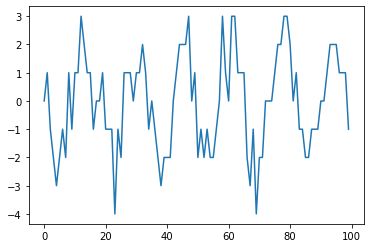

In [14]:
plt.plot(channel1_data_i[0:100])

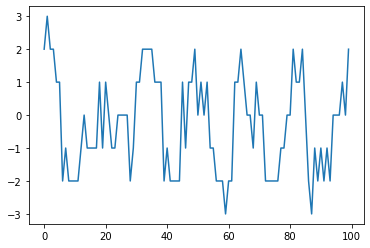

In [15]:
plt.plot(channel1_data_q[0:100])

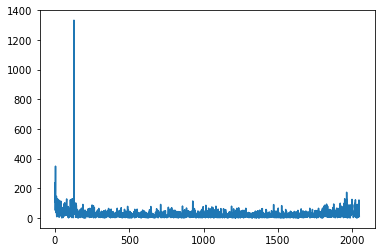

In [16]:
# switch to FFT
switch0.write(0x40,2)
switch0.write(0x44,0)
switch0.write(0x48,1)
switch0.write(0x00,2)

switch1.write(0x40,2)
switch1.write(0x44,0)
switch1.write(0x48,1)
switch1.write(0x00,2)

dma0.recvchannel.transfer(buffer0)
dma1.recvchannel.transfer(buffer1)

mmio1.write(0x4, 1024)
mmio1.write(0x8, 1024)
mmio1.write(0x0, 0)
mmio1.write(0x0, 1)
mmio1.write(0x0, 0)

plt.plot(np.abs(buffer0))

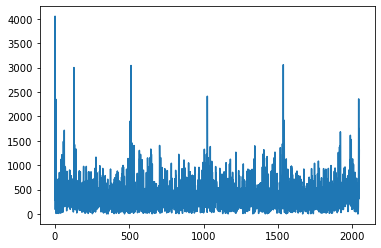

In [17]:
plt.plot(np.abs(buffer1))

In [18]:
ol.free()